In [20]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt


In [21]:
# Open High Low Close
train_data=pd.read_csv('training.csv',header=None)

open_mean=train_data.mean()[0]
open_std=train_data.std()[0]
# print(train_data[0])
# train_data.head()
# train_data.shape

In [22]:
def get_data(df, days_to_train=2, days_to_pred=1):
    # 用前三天預測當天
    X=[]
    Y=[]

    df=df.apply(lambda x:(x-x.mean())/ x.std())
    
    for i in range(df.shape[0]-days_to_train):
        X.append(np.array(df.iloc[i:(i+days_to_train)],dtype=np.float32))
        Y.append(np.array(df.iloc[i+days_to_train,0],dtype=np.float32))

    return np.array(X), np.array(Y)

class DataSet(Dataset):

    def __init__(self,a, b, trans):
        self.train=a
        self.valid=b
        self.transform=trans

    def __getitem__(self, index) :
        x=self.train[index]
        y=self.valid[index]

        x=self.transform(x)
        # y=self.transform(y)

        return x, y

    def __len__(self):

        return len(self.train)

In [23]:
X, Y=get_data(train_data)
print(X.shape)
# print(Y)

train_x, train_y=X[:int(len(X)*0.8)], Y[:int(len(Y)*0.8)]
valid_x, valid_y=X[int(len(X)*0.8):], Y[int(len(Y)*0.8):]

transform=transforms.Compose([
    transforms.ToTensor(),
])
train_loader=DataLoader(dataset=DataSet(train_x, train_y, transform),batch_size=2,shuffle=True)
valid_loader=DataLoader(dataset=DataSet(valid_x, valid_y, transform),batch_size=2,shuffle=True)

# print(len(train_x), len(valid_x))


(1486, 2, 4)
1188 298


In [24]:
class LSTM(torch.nn.Module):
    def __init__(self, input=4, hidden_size=32, output=1):
        # Input of LSTM : batch, sequence_len, input_size
        super(LSTM, self).__init__()

        self.rnn=torch.nn.LSTM(input, hidden_size, batch_first=True)
        self.linear=torch.nn.Linear(hidden_size, output)

    def forward(self,x):
        out, (hidden, cell) = self.rnn(x)
        a, b, c = hidden.shape
        # print(hidden.reshape(a*b,c).shape)
        out = self.linear(hidden.reshape(a*b,c))
        
        return out

# LSTM=torch.nn.LSTM(4,32,batch_first=True)

In [25]:
EPOCH = 50
LR = 0.001

device = 'cpu'
if torch.cuda.is_available(): # 若想使用 cuda 且可以使用 cuda
    device = 'cuda'

print('Using %s'%device)

Using cuda


In [26]:
model = LSTM()
model=model.to(device)
criterion=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr = LR)

print(model)

LSTM(
  (rnn): LSTM(4, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


In [27]:
# Train model

preds=[]
targets=[]

for i in range(EPOCH):
    print('============EPOCH {}============'.format(i+1))
    
    model.train()
    train_loss=0
    n_of_train_loss=0
    for _, (data, label) in enumerate(tqdm(train_loader)):
        data, label = data.to(device), label.to(device)

        optimizer.zero_grad()
        pred=model(data.squeeze())
        label=label.unsqueeze(1)

        loss=criterion(pred, label)

        loss.backward()
        optimizer.step()

        train_loss+=loss.item()
        n_of_train_loss+=1
        # print(label.unsqueeze(1).shape)
        # print(pred.shape)
        # break
        
    

    # Validate model
    model.eval()
    valid_loss = 0
    n_of_valid_loss = 0

    with torch.no_grad():
        for _, (data, label) in enumerate(tqdm(valid_loader)):
            data, label = data.to(device), label.to(device)

            pred=model(data.squeeze())
            # print(data.shape)
            label=label.unsqueeze(1)

            loss = criterion(pred, label)

            valid_loss+=loss.item()
            n_of_valid_loss+=1

            preds.extend(pred.squeeze().tolist())
            targets.extend(label.squeeze().tolist())
            # break
        
        print("Train loss:{}".format(train_loss/n_of_train_loss))
        print("Valid loss:{}".format(valid_loss/n_of_valid_loss))

torch.save(model,'LSTM.pt')

# print(len(preds))
# print(len(targets))

============EPOCH 1============


100%|██████████| 149/149 [00:00<00:00, 1075.03it/s]


Train loss:0.10244302909134784
Valid loss:0.009486174896164507
============EPOCH 2============


100%|██████████| 149/149 [00:00<00:00, 1123.53it/s]


Train loss:0.009167704365725464
Valid loss:0.005065354219234313
============EPOCH 3============


100%|██████████| 149/149 [00:00<00:00, 1131.79it/s]


Train loss:0.007156949395657005
Valid loss:0.0065795593387495644
============EPOCH 4============


100%|██████████| 149/149 [00:00<00:00, 1260.08it/s]


Train loss:0.006354378028981754
Valid loss:0.003303193884438092
============EPOCH 5============


100%|██████████| 149/149 [00:00<00:00, 1098.78it/s]


Train loss:0.005931519407643192
Valid loss:0.0032341077664229958
============EPOCH 6============


100%|██████████| 149/149 [00:00<00:00, 778.12it/s]


Train loss:0.005522305339037388
Valid loss:0.0030849347967156727
============EPOCH 7============


100%|██████████| 149/149 [00:00<00:00, 1204.59it/s]


Train loss:0.005571956160962169
Valid loss:0.0029466591494194242
============EPOCH 8============


100%|██████████| 149/149 [00:00<00:00, 1114.94it/s]


Train loss:0.005056444408256077
Valid loss:0.003206978007325926
============EPOCH 9============


100%|██████████| 149/149 [00:00<00:00, 1176.60it/s]


Train loss:0.00509991268368375
Valid loss:0.002647917752838966
============EPOCH 10============


100%|██████████| 149/149 [00:00<00:00, 1100.43it/s]


Train loss:0.005125067435182726
Valid loss:0.002752983816304281
============EPOCH 11============


100%|██████████| 149/149 [00:00<00:00, 1157.07it/s]


Train loss:0.004937464112532629
Valid loss:0.0029565998750531557
============EPOCH 12============


100%|██████████| 149/149 [00:00<00:00, 1216.69it/s]


Train loss:0.00482457381076299
Valid loss:0.0031711941575495745
============EPOCH 13============


100%|██████████| 149/149 [00:00<00:00, 1097.31it/s]


Train loss:0.004784776662564897
Valid loss:0.002910495605361604
============EPOCH 14============


100%|██████████| 149/149 [00:00<00:00, 1158.36it/s]


Train loss:0.004777062328584844
Valid loss:0.004305195941448355
============EPOCH 15============


100%|██████████| 149/149 [00:00<00:00, 1140.22it/s]


Train loss:0.004631213598695475
Valid loss:0.0028252419507063813
============EPOCH 16============


100%|██████████| 149/149 [00:00<00:00, 1009.45it/s]


Train loss:0.00463803286465987
Valid loss:0.002727655635081286
============EPOCH 17============


100%|██████████| 149/149 [00:00<00:00, 1255.46it/s]


Train loss:0.004523886103100662
Valid loss:0.0028725497215095217
============EPOCH 18============


100%|██████████| 149/149 [00:00<00:00, 1217.82it/s]


Train loss:0.004653383082719418
Valid loss:0.0025533521315046284
============EPOCH 19============


100%|██████████| 149/149 [00:00<00:00, 1086.02it/s]


Train loss:0.004450370045780325
Valid loss:0.0025763022359118035
============EPOCH 20============


100%|██████████| 149/149 [00:00<00:00, 1185.71it/s]


Train loss:0.0043681571935218376
Valid loss:0.002606037010000959
============EPOCH 21============


100%|██████████| 149/149 [00:00<00:00, 1185.70it/s]


Train loss:0.00505889513397204
Valid loss:0.0024574294075796997
============EPOCH 22============


100%|██████████| 149/149 [00:00<00:00, 995.99it/s]


Train loss:0.004454629259629504
Valid loss:0.0032126699388571665
============EPOCH 23============


100%|██████████| 149/149 [00:00<00:00, 1185.81it/s]


Train loss:0.0044728827305030635
Valid loss:0.0025318593408407207
============EPOCH 24============


100%|██████████| 149/149 [00:00<00:00, 1115.14it/s]


Train loss:0.004501905454512106
Valid loss:0.0024293762977313175
============EPOCH 25============


100%|██████████| 149/149 [00:00<00:00, 1110.18it/s]


Train loss:0.0042962876613649205
Valid loss:0.003378042966754788
============EPOCH 26============


100%|██████████| 149/149 [00:00<00:00, 1070.71it/s]


Train loss:0.0047899277449217305
Valid loss:0.0025805876253102633
============EPOCH 27============


100%|██████████| 149/149 [00:00<00:00, 1156.72it/s]


Train loss:0.004470464119338136
Valid loss:0.0027038270733870046
============EPOCH 28============


100%|██████████| 149/149 [00:00<00:00, 1059.56it/s]


Train loss:0.004581737928398952
Valid loss:0.0025220667856126282
============EPOCH 29============


100%|██████████| 149/149 [00:00<00:00, 768.05it/s]


Train loss:0.004658351003931034
Valid loss:0.0031755331007886508
============EPOCH 30============


100%|██████████| 149/149 [00:00<00:00, 1004.50it/s]


Train loss:0.004305530129213343
Valid loss:0.0025730139394428368
============EPOCH 31============


100%|██████████| 149/149 [00:00<00:00, 1131.47it/s]


Train loss:0.004388583128725595
Valid loss:0.00244150510561606
============EPOCH 32============


100%|██████████| 149/149 [00:00<00:00, 1113.81it/s]


Train loss:0.004412619478600229
Valid loss:0.002685509145979591
============EPOCH 33============


100%|██████████| 149/149 [00:00<00:00, 1068.03it/s]


Train loss:0.004281043629707038
Valid loss:0.0025620384713148582
============EPOCH 34============


100%|██████████| 149/149 [00:00<00:00, 1162.66it/s]


Train loss:0.004342964119322619
Valid loss:0.003131146920650464
============EPOCH 35============


100%|██████████| 149/149 [00:00<00:00, 1037.49it/s]


Train loss:0.004451006724362552
Valid loss:0.0024994663400586385
============EPOCH 36============


100%|██████████| 149/149 [00:00<00:00, 1158.14it/s]


Train loss:0.004448517134182822
Valid loss:0.0029893477329084434
============EPOCH 37============


100%|██████████| 149/149 [00:00<00:00, 1244.99it/s]


Train loss:0.004311435438882718
Valid loss:0.0024597197829334984
============EPOCH 38============


100%|██████████| 149/149 [00:00<00:00, 1123.30it/s]


Train loss:0.004457983453853244
Valid loss:0.002506395554833614
============EPOCH 39============


100%|██████████| 149/149 [00:00<00:00, 1214.62it/s]


Train loss:0.004294790863067576
Valid loss:0.002752106921012522
============EPOCH 40============


100%|██████████| 149/149 [00:00<00:00, 1249.85it/s]


Train loss:0.004511546384358274
Valid loss:0.002966039646149426
============EPOCH 41============


100%|██████████| 149/149 [00:00<00:00, 1052.26it/s]


Train loss:0.0044455488078833025
Valid loss:0.0024454932123604374
============EPOCH 42============


100%|██████████| 149/149 [00:00<00:00, 1158.14it/s]


Train loss:0.004280864211727318
Valid loss:0.002464922593939288
============EPOCH 43============


100%|██████████| 149/149 [00:00<00:00, 1266.40it/s]


Train loss:0.004338429217184458
Valid loss:0.0029701019216465297
============EPOCH 44============


100%|██████████| 149/149 [00:00<00:00, 1143.76it/s]


Train loss:0.004369176207539379
Valid loss:0.002438046712452601
============EPOCH 45============


100%|██████████| 149/149 [00:00<00:00, 1140.21it/s]


Train loss:0.004429097194367145
Valid loss:0.002521026818158134
============EPOCH 46============


100%|██████████| 149/149 [00:00<00:00, 1224.31it/s]


Train loss:0.0044644670255375735
Valid loss:0.002958151505737878
============EPOCH 47============


100%|██████████| 149/149 [00:00<00:00, 1106.47it/s]


Train loss:0.004323358321354256
Valid loss:0.0027311715682343056
============EPOCH 48============


100%|██████████| 149/149 [00:00<00:00, 1266.08it/s]


Train loss:0.004256489012503022
Valid loss:0.0025964053169222276
============EPOCH 49============


100%|██████████| 149/149 [00:00<00:00, 1070.69it/s]


Train loss:0.004221291541423076
Valid loss:0.004193022424803817
============EPOCH 50============


100%|██████████| 149/149 [00:00<00:00, 1248.91it/s]

Train loss:0.004285881605868714
Valid loss:0.002860984869714791


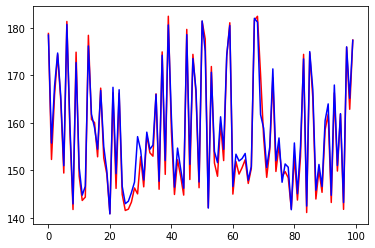

In [28]:
# Test

plt.plot([(i*open_std)+open_mean for i in preds[:100]],'r',label='Prediction')
plt.plot([(i*open_std)+open_mean for i in targets[:100]],'b',label='Real data')
plt.show()

In [29]:
# Test data
test_data=pd.read_csv('testing.csv',header=None)
test_mean, test_std = test_data.mean()[0], test_data.std()[0]
open_price=test_data[0]
test_data=test_data.apply(lambda x:(x-x.mean())/ x.std())

X=[]
days_to_used=2
for i in range(test_data.shape[0]-days_to_used):
    X.append(np.array(test_data.iloc[i:(i+days_to_used)],dtype=np.float32))
test_set=np.array(X)
# print(test_set.shape)
test_set=transform(test_set)
test_set=test_set.permute(1, 2, 0)
# print(test_set.shape)
test_set=test_set.to(device)

# for _, (data, label) in enumerate((valid_loader)):
#     print(data.shape)
#     break
model.eval()
with torch.no_grad():
    test_pred=model(test_set)
test_pred=test_pred.squeeze().tolist()
test_pred.insert(0,0)
test_pred.insert(0,0)
# print(test_pred)

# plt.plot([(i*test_std)+test_mean for i in test_pred],'r',label='Prediction')
# plt.plot(open_price,'b',label='Real data')
# plt.show()

actions=[]
unit=0
my_price=0
for i in range(len(open_price)-1):
    
    if i < 1:
        actions.append(0)
        continue

    today_price=open_price[i]
    pred_price=test_pred[i+1]*test_std+test_mean
    if my_price < pred_price and unit == 1:
        # Sell
        actions.append(-1)
        unit-=1
    elif today_price > pred_price and unit == 0:
        # Buy
        actions.append(1)
        my_price=open_price[i+1]
        unit+=1
    else:
        actions.append(0)
    # print(i)

submission=pd.DataFrame({
    'Action':actions
})
submission.to_csv('output.csv',header=None, index=False)

# print(submission)

